In [1]:
!pip install thop shapely --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requ

# Config

In [2]:
import os, math, random, time, warnings
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

try:
    from thop import profile
except Exception:
    profile = None
from sklearn.metrics import precision_recall_curve, average_precision_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
# -----------------------------
# Config
# -----------------------------
class CFG:
    BASE_PATH = "/kaggle/input/3dlidar"
    BIN_DIR   = "bin"
    LABEL_DIR = "label"
    CLASSES   = ['FTS', 'ELFplusplus', 'CargoBike', 'Box', 'ForkLift']
    NUM_POINTS = 4096
    SEED = 42

    # Detection
    FEAT_DIM = 128
    DET_EPOCHS = 50  
    DET_BATCH_SIZE = 16
    DET_LR = 1e-3
    DET_WD = 1e-4
    DET_SAVE_DIR = "/kaggle/working/det_point_yolo"
    DET_MODEL_PATH = os.path.join(DET_SAVE_DIR, "best_detector.pth")
    # SSL backbone from Session 4
    SSL_BACKBONE_PATH = "/kaggle/input/ssl-checkpoints-epoch100/ssl_point_coco_yolo/ssl_backbone.pth"

    # Eval/Training
    FP16 = torch.cuda.is_available()
    EVAL_CONF_THR = 0.10
    EVAL_NMS_THR = 0.45
    EVAL_IOU_THRESHOLDS = np.linspace(0.5, 0.95, 10)

os.makedirs(CFG.DET_SAVE_DIR, exist_ok=True)
random.seed(CFG.SEED); np.random.seed(CFG.SEED); torch.manual_seed(CFG.SEED)
NUM_CLASSES = len(CFG.CLASSES)

# Helper Functions

In [4]:
# -----------------------------
# Geometry helpers
# -----------------------------
def rotz(yaw):
    c, s = math.cos(yaw), math.sin(yaw)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]], np.float32)

def bev_poly(center, size, yaw):
    cx, cy = center[:2]; sx, sy = size[:2]
    pts = np.array([[-sx/2,-sy/2],[ sx/2,-sy/2],[ sx/2, sy/2],[-sx/2, sy/2]], np.float32)
    R = np.array([[math.cos(yaw), -math.sin(yaw)],[math.sin(yaw), math.cos(yaw)]])
    return (R @ pts.T).T + np.array([cx, cy])

def poly_iou(p1, p2):
    P1, P2 = Polygon(p1), Polygon(p2)
    if not P1.is_valid or not P2.is_valid: return 0.0
    inter = P1.intersection(P2).area
    union = P1.union(P2).area + 1e-6
    return float(inter / union)

def fast_bev_iou(b1, b2):
    x1_min, x1_max = b1[0]-b1[3]/2, b1[0]+b1[3]/2
    y1_min, y1_max = b1[1]-b1[4]/2, b1[1]+b1[4]/2
    x2_min, x2_max = b2[0]-b2[3]/2, b2[0]+b2[3]/2
    y2_min, y2_max = b2[1]-b2[4]/2, b2[1]+b2[4]/2
    inter_x = max(0.0, min(x1_max, x2_max) - max(x1_min, x2_min))
    inter_y = max(0.0, min(y1_max, y2_max) - max(y1_min, y2_min))
    inter = inter_x * inter_y
    union = (b1[3]*b1[4] + b2[3]*b2[4] - inter) + 1e-6
    return inter / union

def yaw_loss(pred, gt):
    return (1.0 - torch.cos(pred - gt)).mean()

# -----------------------------
# Dataset helpers
# -----------------------------
def load_point_cloud(bin_path):
    arr = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return arr[:, :3].astype(np.float32)

def parse_label_file(path):
    if not os.path.exists(path): return np.zeros((0,8), np.float32)
    out = []
    for ln in open(path).read().strip().splitlines():
        cls, x, y, z, sx, sy, sz, yaw = ln.strip().split()
        if cls not in CFG.CLASSES: continue
        out.append([CFG.CLASSES.index(cls), float(x), float(y), float(z), float(sx), float(sy), float(sz), float(yaw)])
    return np.array(out, np.float32) if out else np.zeros((0,8), np.float32)

def sample_pc(pc, n_points):
    if pc.shape[0] > n_points:
        return pc[np.random.choice(pc.shape[0], n_points, replace=False)]
    else:
        return pc[np.random.choice(pc.shape[0], n_points, replace=True)]

def augment_pc(pc):
    yaw = random.uniform(-math.pi/6, math.pi/6)
    R = rotz(yaw)
    pc = pc @ R.T
    scale = random.uniform(0.9, 1.1)
    pc = pc * scale
    jitter = np.random.normal(0, 0.01, pc.shape)
    pc = pc + jitter
    return pc.astype(np.float32)

# -----------------------------
# Checkpoint helpers
# -----------------------------
def load_ssl_weights(model, backbone_path=CFG.SSL_BACKBONE_PATH):
    if os.path.exists(backbone_path):
        ssl_state = torch.load(backbone_path, map_location=DEVICE)
        try:
            # Handle DataParallel compatibility
            if isinstance(model, nn.DataParallel):
                model.module.backbone.load_state_dict(ssl_state, strict=False)
            else:
                model.backbone.load_state_dict(ssl_state, strict=False)
            print(f"[SSL] Loaded pre-trained backbone weights from {backbone_path}")
        except Exception as e:
            print(f"[SSL] Warning: failed to load backbone state dict cleanly: {e}")
            # Attempt to load with key renaming
            state_dict = {k.replace("module.", ""): v for k, v in ssl_state.items()}
            if isinstance(model, nn.DataParallel):
                model.module.backbone.load_state_dict(state_dict, strict=False)
            else:
                model.backbone.load_state_dict(state_dict, strict=False)
            print(f"[SSL] Loaded weights with key renaming from {backbone_path}")
    else:
        print(f"[SSL] No pre-trained weights found at {backbone_path}")

def save_detector_checkpoint(model, opt, epoch, val_loss, path=CFG.DET_MODEL_PATH):
    ckpt = {
        "epoch": epoch,
        "model_state_dict": model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "val_loss": val_loss
    }
    torch.save(ckpt, path)

# Models and Datasets

In [5]:
# -----------------------------
# Models
# -----------------------------
class PointBackbone(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, feat), nn.ReLU()
        )
        self.bn = nn.BatchNorm1d(feat)
    def forward(self, x):
        # x: (B,N,3) -> f: (B,N,feat)
        f = self.mlp(x)
        return self.bn(f.transpose(1,2)).transpose(1,2)

class YOLO3DHead(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.pred = nn.Sequential(nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, 7 + 1 + num_classes))
    def forward(self, f): return self.pred(f)

class YOLO3D(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feat_dim=CFG.FEAT_DIM):
        super().__init__()
        self.backbone = PointBackbone(feat_dim)
        self.head = YOLO3DHead(feat=feat_dim, num_classes=num_classes)
    def forward(self, pc):
        f = self.backbone(pc)      # (B,N,feat)
        pred = self.head(f)        # (B,N,7+1+num_classes)
        return pred

# -----------------------------
# Dataset classes
# -----------------------------
class DetDataset(Dataset):
    def __init__(self, base, idxs, augment=False):
        self.base = base
        self.bin_dir = os.path.join(base, CFG.BIN_DIR)
        self.lab_dir = os.path.join(base, CFG.LABEL_DIR)
        files = sorted([f for f in os.listdir(self.bin_dir) if f.endswith(".bin")])
        self.files = [files[i] for i in idxs]
        self.augment = augment
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        f = self.files[i]
        pc = load_point_cloud(os.path.join(self.bin_dir, f)); pc = sample_pc(pc, CFG.NUM_POINTS)
        gts = parse_label_file(os.path.join(self.lab_dir, f.replace(".bin", ".txt")))
        if self.augment:
            yaw = random.uniform(-math.pi/6, math.pi/6)
            R = rotz(yaw)
            pc = pc @ R.T
            if len(gts) > 0:
                for row in gts:
                    row[1:4] = (R @ row[1:4].copy().reshape(3,1)).reshape(3,)
                    row[7] += yaw
        return torch.from_numpy(pc).float(), torch.from_numpy(gts).float()

def collate_det(b): pcs, gts = zip(*b); return torch.stack(pcs, 0), list(gts)

# Losses & training steps

In [6]:
# -----------------------------
# Losses & training steps
# -----------------------------
def yolo3d_loss(pred, gt_list):
    B, N, C = pred.shape
    loss_box = loss_conf = loss_cls = 0.0
    n_pos = 0
    for b in range(B):
        gt = gt_list[b].to(pred.device)
        pbox = pred[b, :, :7]
        conf = pred[b, :, 7]
        pcls = pred[b, :, 8:]
        if gt.numel() == 0:
            loss_conf += F.binary_cross_entropy_with_logits(conf, torch.zeros_like(conf))
            continue
        pos_mask = torch.zeros(N, dtype=torch.bool, device=pred.device)
        for g in gt:
            cls = int(g[0].item())
            d = torch.norm(pbox[:, :3] - g[1:4], dim=1)
            min_id = torch.argmin(d)
            pos_mask[min_id] = True
            loss_box += F.smooth_l1_loss(pbox[min_id, :6], g[1:7])
            loss_box += yaw_loss(pbox[min_id, 6], g[7])
            loss_conf += F.binary_cross_entropy_with_logits(conf[min_id], torch.ones((), device=pred.device))
            loss_cls += F.cross_entropy(pcls[min_id].unsqueeze(0), torch.tensor([cls], device=pred.device))
            n_pos += 1
        if (~pos_mask).sum() > 0:
            loss_conf += F.binary_cross_entropy_with_logits(conf[~pos_mask], torch.zeros_like(conf[~pos_mask]))
    denom = max(1, n_pos)
    total = (loss_box + loss_conf + loss_cls) / denom
    return total, {"box": float(loss_box/denom), "conf": float(loss_conf/denom), "cls": float(loss_cls/denom)}

def run_det_epoch(model, loader, opt, scaler, pbar):
    model.train()
    running_loss = 0.0
    for pc, gt_list in loader:
        pc = pc.to(DEVICE)
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            out = model(pc)
            loss, parts = yolo3d_loss(out, gt_list)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        running_loss += loss.item()
        pbar.update(1)
        pbar.set_postfix(loss=f"{loss.item():.4f}", **parts)
    return running_loss / max(1, len(loader))

@torch.no_grad()
def run_det_val(model, loader, pbar):
    model.eval()
    running = []
    for pc, gt_list in loader:
        pc = pc.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            out = model(pc)
            loss, _ = yolo3d_loss(out, gt_list)
        running.append(loss.item())
        pbar.update(1)
        pbar.set_postfix(loss=loss.item())
    return float(np.mean(running)) if running else 0.0

# Detector Training

[SSL] Loaded pre-trained backbone weights from /kaggle/input/ssl-checkpoints-epoch100/ssl_point_coco_yolo/ssl_backbone.pth


[DET 1/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 1/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 01] Train=2.8048 Val=2.4540
  -> Saved best detector ckpt (val=2.4540)


[DET 2/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 2/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 02] Train=2.4091 Val=2.1928
  -> Saved best detector ckpt (val=2.1928)


[DET 3/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 3/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 03] Train=2.2909 Val=2.1189
  -> Saved best detector ckpt (val=2.1189)


[DET 4/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 4/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 04] Train=2.1091 Val=1.9919
  -> Saved best detector ckpt (val=1.9919)


[DET 5/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 5/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 05] Train=1.9843 Val=1.8931
  -> Saved best detector ckpt (val=1.8931)


[DET 6/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 6/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 06] Train=2.0594 Val=1.9761


[DET 7/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 7/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 07] Train=2.0445 Val=1.9257


[DET 8/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 8/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 08] Train=1.9894 Val=1.7815
  -> Saved best detector ckpt (val=1.7815)


[DET 9/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 9/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 09] Train=2.0018 Val=1.8124


[DET 10/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 10/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 10] Train=1.9510 Val=2.0170


[DET 11/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 11/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 11] Train=2.1142 Val=1.8621


[DET 12/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 12/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 12] Train=2.0694 Val=2.0030


[DET 13/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 13/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 13] Train=1.9570 Val=1.8895


[DET 14/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 14/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 14] Train=2.0784 Val=2.0325


[DET 15/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 15/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 15] Train=2.1600 Val=2.0012


[DET 16/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 16/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 16] Train=2.0625 Val=1.8288


[DET 17/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 17/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 17] Train=2.0039 Val=1.9736


[DET 18/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 18/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 18] Train=2.0057 Val=1.8568


[DET 19/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 19/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 19] Train=1.9981 Val=1.8550


[DET 20/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 20/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 20] Train=1.9490 Val=1.6192
  -> Saved best detector ckpt (val=1.6192)


[DET 21/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 21/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 21] Train=1.8654 Val=1.8409


[DET 22/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 22/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 22] Train=1.9438 Val=1.6803


[DET 23/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 23/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 23] Train=1.9421 Val=1.7601


[DET 24/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 24/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 24] Train=1.9730 Val=2.0604


[DET 25/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 25/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 25] Train=1.9412 Val=1.7423


[DET 26/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 26/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 26] Train=2.1911 Val=2.0438


[DET 27/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 27/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 27] Train=2.1416 Val=1.9983


[DET 28/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 28/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 28] Train=2.1224 Val=1.9329


[DET 29/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 29/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 29] Train=2.0585 Val=1.8939


[DET 30/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 30/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 30] Train=1.9932 Val=1.7665


[DET 31/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 31/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 31] Train=1.9686 Val=1.8043


[DET 32/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 32/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 32] Train=1.8709 Val=1.7830


[DET 33/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 33/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 33] Train=1.9096 Val=2.1139


[DET 34/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 34/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 34] Train=1.9638 Val=1.6209


[DET 35/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 35/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 35] Train=1.9769 Val=1.8108


[DET 36/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 36/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 36] Train=1.9827 Val=1.8733


[DET 37/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 37/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 37] Train=1.9639 Val=1.7747


[DET 38/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 38/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 38] Train=1.9280 Val=1.8227


[DET 39/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 39/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 39] Train=1.9333 Val=1.7804


[DET 40/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 40/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 40] Train=1.9631 Val=2.0263


[DET 41/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 41/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 41] Train=1.9254 Val=1.7108


[DET 42/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 42/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 42] Train=1.9435 Val=1.9660


[DET 43/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 43/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 43] Train=1.9204 Val=2.0094


[DET 44/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 44/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 44] Train=2.0111 Val=1.8819


[DET 45/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 45/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 45] Train=1.9716 Val=1.7663


[DET 46/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 46/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 46] Train=1.8367 Val=1.7585


[DET 47/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 47/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 47] Train=1.9422 Val=1.9147


[DET 48/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 48/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 48] Train=1.9266 Val=1.8035


[DET 49/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 49/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 49] Train=2.0009 Val=1.8298


[DET 50/50] Train:   0%|          | 0/165 [00:00<?, ?it/s]

[DET 50/50] Val:   0%|          | 0/42 [00:00<?, ?it/s]

[DET Epoch 50] Train=1.9741 Val=2.0274


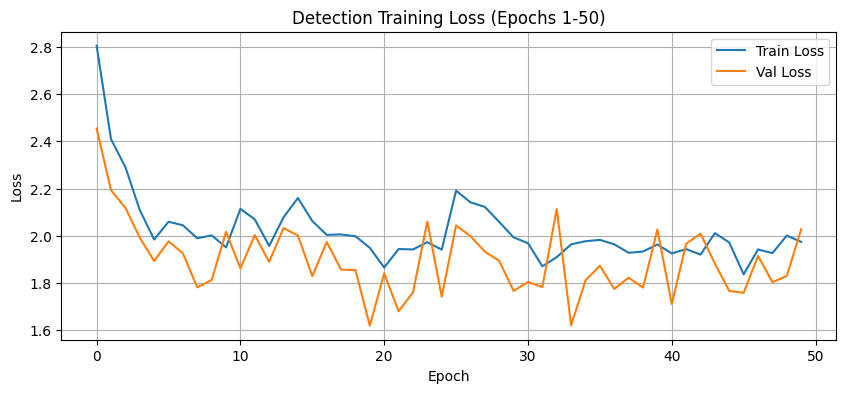

True

In [7]:
# -----------------------------
# Detector Training 
# -----------------------------
def train_detector(load_backbone=True, plot_curve=True):
    base = CFG.BASE_PATH
    files = sorted([f for f in os.listdir(os.path.join(base, CFG.BIN_DIR)) if f.endswith(".bin")])
    idxs = np.arange(len(files)); np.random.shuffle(idxs)
    n_val = int(0.2 * len(files))
    val_idx, train_idx = idxs[:n_val], idxs[n_val:]
    train_ds = DetDataset(base, train_idx, augment=True)
    val_ds = DetDataset(base, val_idx, augment=False)
    train_dl = DataLoader(train_ds, batch_size=CFG.DET_BATCH_SIZE, shuffle=True, collate_fn=collate_det)
    val_dl = DataLoader(val_ds, batch_size=CFG.DET_BATCH_SIZE, shuffle=False, collate_fn=collate_det)

    model = YOLO3D(num_classes=NUM_CLASSES, feat_dim=CFG.FEAT_DIM).to(DEVICE)
    if load_backbone:
        load_ssl_weights(model, CFG.SSL_BACKBONE_PATH)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    opt = torch.optim.AdamW(model.parameters(), lr=CFG.DET_LR, weight_decay=CFG.DET_WD)
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.FP16)

    best_val = float('inf')
    train_losses = []
    val_losses = []

    # Initialize CSV for metrics
    metrics_file = os.path.join(CFG.DET_SAVE_DIR, "det_training_metrics.csv")
    try:
        with open(metrics_file, 'w') as f:
            f.write("Epoch,Train_Loss,Val_Loss\n")
            f.flush()
    except Exception as e:
        print(f"[DET] Error initializing metrics CSV: {e}")

    for ep in range(1, CFG.DET_EPOCHS + 1):
        pbar = tqdm(total=len(train_dl), desc=f"[DET {ep}/{CFG.DET_EPOCHS}] Train")
        train_loss = run_det_epoch(model, train_dl, opt, scaler, pbar)
        pbar.close()
        train_losses.append(train_loss)

        pbarv = tqdm(total=len(val_dl), desc=f"[DET {ep}/{CFG.DET_EPOCHS}] Val")
        val_loss = run_det_val(model, val_dl, pbarv)
        pbarv.close()
        val_losses.append(val_loss)

        print(f"[DET Epoch {ep:02d}] Train={train_loss:.4f} Val={val_loss:.4f}")
        
        # Save metrics to CSV
        try:
            with open(metrics_file, 'a') as f:
                f.write(f"{ep},{train_loss:.4f},{val_loss:.4f}\n")
                f.flush()
        except Exception as e:
            print(f"[DET] Error writing to metrics CSV: {e}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            save_detector_checkpoint(model, opt, ep, val_loss)
            print(f"  -> Saved best detector ckpt (val={best_val:.4f})")

    # Plot curves
    if plot_curve:
        plt.figure(figsize=(10,4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.title("Detection Training Loss (Epochs 1-50)")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
        plt.savefig(os.path.join(CFG.DET_SAVE_DIR, "det_loss_curve.png"))
        plt.show()

    return os.path.exists(CFG.DET_MODEL_PATH)

train_detector(load_backbone=True)